In [1]:
import os
os.chdir('..') # this resolves ImportError: attempted relative import with no known parent package

# general DS packages
import pandas as pd
import numpy as np

# cleaning and pre-processing
from nltk.tokenize import RegexpTokenizer
from src.processing.text_cleaning import (normalize_text, process_contractions, remove_all_punctuation, remove_emojis, 
remove_html_unescape, remove_href_pattern, remove_digits, remove_extra_whitespace, remove_website_links)

from src.processing.text_processing import (tokenize_comment, lemmatize_comment, remove_stop_words, remove_tiny_tokens, 
remove_tekken_character_names_from_tokens, part_of_speech, part_of_speech_tag, part_of_speech_dependency, part_of_speech_shape, 
part_of_speech_alpha, part_of_speech_is_stop, word_count, unique_words_from_tokens)

from src.modeling.topic_dataframe import topic_dataframe, _heaviest_words_indices

# modeling
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# visualisation
import matplotlib.pyplot as plt

# other
from operator import itemgetter

# Load the data

In [2]:
# import data from csv
raw_data = pd.read_csv("data/raw/new_character_reveal_comments.csv", )
data = raw_data.copy()
df = pd.DataFrame(data)

# Clean and process data

In [3]:
%%time

# clean
df['textDisplay'] = df['textDisplay'].apply(normalize_text)
df['textDisplay'] = df['textDisplay'].apply(process_contractions)
df['textDisplay'] = df['textDisplay'].apply(remove_website_links)
df['textDisplay'] = df['textDisplay'].apply(remove_html_unescape)
df['textDisplay'] = df['textDisplay'].apply(remove_emojis)
df['textDisplay'] = df['textDisplay'].apply(remove_digits)
df['textDisplay'] = df['textDisplay'].apply(remove_all_punctuation)
df['textDisplay'] = df['textDisplay'].apply(remove_href_pattern)
df['textDisplay'] = df['textDisplay'].apply(remove_extra_whitespace)

# process
df["textDisplayWordCount"] = df['textDisplay'].apply(word_count)
df["textStopWordsRemoved"] = df["textDisplay"].apply(remove_stop_words)
df["textTokenized"] = df['textStopWordsRemoved'].apply(tokenize_comment)
df["textLemmatized"] = df["textStopWordsRemoved"].apply(lemmatize_comment)
# remove short meaningless tokens from lemmatized tokens
df["textLemmatized"] = df['textLemmatized'].apply(remove_tiny_tokens)
df["textTekkenCharactersRemoved"] = df["textLemmatized"].apply(remove_tekken_character_names_from_tokens)
df["textProcessedCharactersRemoved"] = df["textTekkenCharactersRemoved"].apply(lambda x: ' '.join(x))

# part of speech operations
df["pos"] = df["textStopWordsRemoved"].apply(part_of_speech)
df["posTag"] = df["textStopWordsRemoved"].apply(part_of_speech_tag)
df["posDependency"] = df["textStopWordsRemoved"].apply(part_of_speech_dependency)
df["posShape"] = df["textStopWordsRemoved"].apply(part_of_speech_shape)
df["posAlpha"] = df["textStopWordsRemoved"].apply(part_of_speech_alpha)
df["posStopWord"] = df["textStopWordsRemoved"].apply(part_of_speech_is_stop)


# remove rows with empty strings in the 'textProcessedCharactersRemoved' column as these will have nothing to pass to the vectorizer when we come to transforming the text input
# to numerical input
df = df[df["textProcessedCharactersRemoved"].astype(str) != '']
df.reset_index(drop=True, inplace=True)

df.head()

CPU times: user 38.3 s, sys: 30 ms, total: 38.4 s
Wall time: 38.4 s


,videoId,authorDisplayName,publishedAt,updatedAt,likeCount,totalReplyCount,textDisplay,textDisplayWordCount,textStopWordsRemoved,textTokenized,textLemmatized,textTekkenCharactersRemoved,textProcessedCharactersRemoved,pos,posTag,posDependency,posShape,posAlpha,posStopWord
0,rDxrpSqYHD8,@faizaanjaved7150,2023-11-01 16:10:05+00:00,2023-11-01 16:10:05+00:00,1,1,already seen it you are getting less views now...,10,seen getting views bamco,"[seen, getting, views, bamco]","[see, get, view, bamco]","[see, get, view, bamco]",see get view bamco,"[VERB, VERB, NOUN, NOUN]","[VBN, VBG, NNS, NNS]","[ROOT, xcomp, dobj, dobj]","[xxxx, xxxx, xxxx, xxxx]","[True, True, True, True]","[False, False, False, False]"
1,rDxrpSqYHD8,@TS-rw4lk,2023-11-01 16:10:05+00:00,2023-11-01 16:10:05+00:00,0,0,wow,1,wow,[wow],[wow],[wow],wow,[INTJ],[UH],[ROOT],[xxx],[True],[False]
2,rDxrpSqYHD8,@ALONCAK,2023-11-01 16:10:06+00:00,2023-11-01 16:10:06+00:00,0,0,oww yeaah,2,oww yeaah,"[oww, yeaah]","[oww, yeaah]","[oww, yeaah]",oww yeaah,"[PROPN, PROPN]","[NNP, NNP]","[compound, ROOT]","[xxx, xxxx]","[True, True]","[False, False]"
3,rDxrpSqYHD8,@Rough_Estimates,2023-11-01 16:10:06+00:00,2023-11-01 16:10:06+00:00,150,18,i hope we get an angel version of jin,9,hope angel version jin,"[hope, angel, version, jin]","[hope, angel, version, jin]","[hope, version]",hope version,"[PROPN, PROPN, PROPN, PROPN]","[NNP, NNP, NNP, NNP]","[compound, compound, compound, ROOT]","[xxxx, xxxx, xxxx, xxx]","[True, True, True, True]","[False, False, False, False]"
4,rDxrpSqYHD8,@kazamataurus337,2023-11-01 16:10:08+00:00,2023-11-01 16:10:08+00:00,1,0,so it begins,3,begins,[begins],[begin],[begin],begin,[VERB],[VBZ],[ROOT],[xxxx],[True],[False]


# Non-negative Matrix Factorisation (NMF)
- At this point we have the text processed and avaibale in tokenized format and as a string.
- We now need to turn the text into numbers...
    - This can be done in a variety of ways e.g., TF-IDF, bag of words (which we previously used gensim to create as part of the LDA model)
    - We're going to use TF-IDF to create the features.
- Once the features are created we can then create a topic model.

## Create and fit vectorizer

In [4]:
# store all the comments in a variable
texts = df['textTekkenCharactersRemoved']

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,  # ignore words that appear in less than x of the youtube comments
    max_df=0.85,   # ignore words that appear in more than x% of the comments
    max_features=999,   # each word will become a feature, set the max we want
    ngram_range=(1, 2),   # allow tf-idf weights for bigrams
    preprocessor=' '.join   # the model will tokenize everything by default so we need to join the tokenized words
)

# fit and transform the text input
tfidf = tfidf_vectorizer.fit_transform(texts)

## Create NMF model
- Manually set the number of topics to discover to 10; we'll use coherence score later to determine the best number of topics

In [5]:
# create and fit the NMF model with scikit-learn NMF
nmf = NMF(
    n_components=10,   # manually select number of topics
    init='nndsvd',   # ‘nndsvd’ initialiser works well on sparse data
    max_iter=100,
    random_state=42
).fit(tfidf)

nmf

NMF(init='nndsvd', max_iter=100, n_components=10, random_state=42)

## Using scikit-learn and gensim to build an optimised model 
- scikit-learn's NMF implementations enables us to use TF-IDF, however scikit-learn's NMF model doesn't have a built-in coherence score functionality, and we need the coherence score to help determine the optimal number of topics.
- So, we'll use gensim's Nmf and coherence score to get the optimum number of topics and then manually select this number of topics with scikit-learn's implementation so we can use TF-IDF instead of gensim's bag of words approach.
- This way we get the benefits of TF-IDF and select the optimal number of topics.

### Why use TF-IDF?

TF-IDF is superior to Bag of Words because:
- Both are common ways of representing text representation in numerical format.
- TF-IDF addresses the weaknesses of Bag of Words, namely TF-IDF:
    - De-emphasises common words and focusses on unique words
    - Results in sparser feature vectors, with many zero values corresponding to irrelevant words. This can be beneficial for certain machine learning algorithms that perform better with sparse data, leading to improved model performance and interpretability.
    - The above helps overcome the word frequency bias that occurs with BoW which simply counts word occurrences, favoring frequent words regardless of their significance.

## Use Gensim to get the optimal number of topics
- Use Bag of Words approach to create a corpus.
- Use gensim Nmf to create a model, try varios topic numbers and get the coherence score for each.

### Create corpus using Bag of Words

In [6]:
# store all the comments in a variable
texts = df['textTekkenCharactersRemoved']

# create a gensim dictionary (words and their id)
dictionary = Dictionary(texts)

# filter out upper and lower extremes to limit the number of features (don't include words occurring less than 3 times or in >85% of comments)
dictionary.filter_extremes(no_below=3, 
                           no_above=0.85, 
                           keep_n=5000)

# create the bag-of-words corpus (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

### Use Gensim Nmf to create model and find optimal number of topics

In [7]:
# create a list of the topic numbers we want to try
topic_numbers = list(np.arange(5, 50, 5))

# run the nmf model and calculate the coherence score for each number of topics
coherence_scores = []

for number_of_topics in topic_numbers:
    nmf = Nmf(
        corpus=corpus,
        num_topics=number_of_topics,
        id2word=dictionary,
        chunksize=1000,   # number of documents to process at a time during model training, impacts memory usage and computational efficiency
        passes=5,   # number of complete passes over the corpus during training; more passes leads to better topic refinement but increases time
        kappa=.1,    # regularization parameter that controls model sparsity. Higher values encourage sparser topics, potentially leading to more distinct and interpretable results.
        minimum_probability=0.01,   # The minimum probability threshold for filtering out low-probability words from topics; helps focus on the most representative words for each topic.
        w_max_iter=300,   # The maximum number of iterations for updating the W (document-topic) and H (topic-word) matrices, respectively. 
                          # They control model convergence and can be adjusted based on model complexity and dataset size.
        w_stop_condition=0.0001,   # The convergence thresholds for W and H updates. Training stops when changes in these matrices fall below these thresholds.
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,   # Evaluate model perplexity on the corpus every eval_every iterations.
        normalize=True,   # Normalize document vectors before NMF factorization. It can improve convergence and topic quality in some cases.
        random_state=42
    )
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 3))


# get the number of topics with the highest coherence score
scores = list(zip(topic_numbers, coherence_scores))

# sort the coherence from highest to lowest and access the number of topics associated with the highest coherence score 
best_number_of_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]    # access the first element of the (number_of_topics, coherence score) tuple
                                                                                 # key=itemgetter(1) specifies that the sorting should be done using the value 
                                                                                 # at index 1 of each element as the key (the coherence score)
best_number_of_topics

30

# Visualise coherence score and number of topics

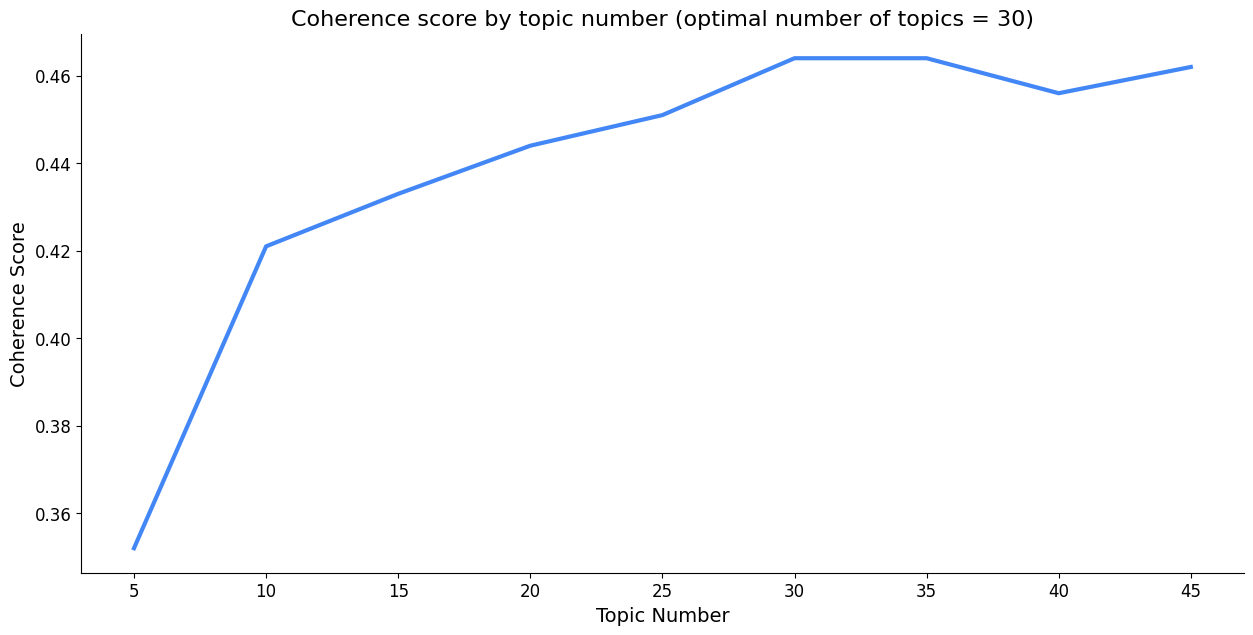

Number of topics with highest coherence score: 30
Coherence score: 0.464


In [8]:
fig, ax = plt.subplots(figsize=(15, 7))

plt.plot(
    topic_numbers,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Number", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title(f"Coherence score by topic number (optimal number of topics = {best_number_of_topics})", fontsize=16)
plt.xticks(np.arange(5, max(topic_numbers) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

# remove plot box outline (spines)
spines = ax.spines
spines['top'].set_visible(False)
spines['right'].set_visible(False)
# ax.tick_params(bottom=False, left=False)

plt.show()

# print summary
print(f"Number of topics with highest coherence score: {best_number_of_topics}\n"
      f"Coherence score: {[item[1] for item in scores if item[0] == best_number_of_topics][0]}")


# save image
fig.savefig(f"images/coherence_score_{[item[1] for item in scores if item[0] == best_number_of_topics][0]}_number_of_topics_{best_number_of_topics}.png")

## Number of topics
- 30 seems like a lot... we'll likely need to experiment with this number. We can see that 10 topics has a coherence score of 0.42 so this may well be fine for the use case as 10 key topics seems more sensible; what's more important is the words making up these topics.
- Trial and error and experimentation may find more optimal topic numbers, and once we can see what words are making up each topic then we'll be able to ascertain:
    1. If the topics make sense
    2. If there is any similarity between topics.

# Create NMF model using TF-IDF and the optimal number of topics
- Now that we have an 'optimal' number of topics we can use _scikit-learn_ to create an NMF model that uses TF-IDF to vectorize.
- The first step is to create a TF-IDF vectorizer...

In [9]:
# store the text input (all the comments) that we'll transform into numerical format in a variable
texts = df['textTekkenCharactersRemoved']

# create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,  # discard words in less than 3 documents
    max_df=0.85,    # discard words in more than 85% of documents
    max_features=999, 
    ngram_range=(1, 2),   # enable bigrams
    preprocessor=' '.join   # joins each list of words within a document into a single string, creating the expected string 
                            # representation for each document.
)

tfidf_vectorizer

TfidfVectorizer(max_df=0.85, max_features=999, min_df=3, ngram_range=(1, 2),
                preprocessor=<built-in method join of str object at 0x1050b5330>)

Now that we have a vectoizer created we can use it to fit and transform our input data. _fit_ learns the vocab (terms) and frequencies, _transform_ takes the knowledge gained during fit and applies it to transform raw text into a structured, numerical representation that machines can effectively analyze 

In [10]:
# fit and transform
tfidf = tfidf_vectorizer.fit_transform(texts)   

## Feature names and TF-IDF score
- We can view the feature names of the TF-IDF vectorizer; the feature names refer to the actual terms (words or phrases) that have been used to create the numerical representation; the feature names are the vocabulary of the vectorizer.
- Each feature name (word or phrase) will have a TF-IDF score associated with it for each document; the TF-IDF score reflects the word or phrase's unique usage pattern compared to the entire corpus.
- Higher scores indicate terms that are more statistically relevant and informative for that specific document.

In [11]:
# store the feature names in a variable - we'll use these later for topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# store the TF-IDF scores associated with each word for each document
tfidf_matrix = tfidf.toarray()

print(f"There are {len(tfidf_feature_names)} features (words) in our TF-IDF vectorizer")
print(f"First 10 words:\n{tfidf_feature_names[:10]}")

There are 544 features (words) in our TF-IDF vectorizer
First 10 words:
['able' 'absolutely' 'actor' 'actual' 'actually' 'actually look' 'add'
 'aesthetic' 'alisas' 'alright']


### Viewing the TF-IDF scores
- We can loop through the items and values in our TF-IDF matrix and get the TF-IDF score for each word in each comment.
- Each item in the TF-IDF matrix is a list with a length equal to the number of features (words), and each value in the list is the TF-IDF score for a given word. 
- Most of the TF-IDF values will therefore be 0.0 as each comment will only have a small number of words.
- Therefore, we can apply an if logic that checks if the word has a score of >0.0 so that we only get a view of the words that actually have scores for a given comment.

In [12]:
type(tfidf_matrix)

numpy.ndarray

In [13]:
len(tfidf_matrix)

1739

The length of the matrix is equal to the number of comments we have in our data.

In [14]:
len(tfidf_feature_names)

544

The length of the feature names is equal to the number of words we have as features.

In [15]:
len(tfidf_matrix[0])

544

Each item in our matrix has a length equal to the feature names as each item will contain a TF-IDF score for each word (so it will contain lots of 0.0 vales (a sparse matrix)).

In [16]:
# loop through the first 10 comments and get the words and their TF-IDF score
for index, values in enumerate(tfidf_matrix[:10]):
    print(f"\nComment {index + 1}:")
    for word_index, tfidf_score in enumerate(values):
        if tfidf_score >0.0:    
            word_index = int(word_index)   # indexing issue as for some reason the word index was a float
            print(f"{tfidf_feature_names[word_index]}: {round(tfidf_score, 3)}")


Comment 1:
bamco: 0.548
get: 0.363
see: 0.464
view: 0.595

Comment 2:
wow: 1.0

Comment 3:

Comment 4:
hope: 0.522
version: 0.853

Comment 5:

Comment 6:
right: 1.0

Comment 7:
let: 1.0

Comment 8:
wow: 1.0

Comment 9:
marvelous: 1.0

Comment 10:
bandai: 0.639
late: 0.769


## Visualising the TF-IDF scores for comments
- We can get an idea of what the TF-IDF scores look like for the documents (comments).
- To do this we can create a bar chart, with the words in our corpus on the x axis and the TF-IDF score on the y-axis.
- We'll create individual graphs for each document (comment); however we have over 1,000 comments, and 544 words in our corpus so we'll just visualise the TF-IDF scores for a few comments, and only include the words with a score greater than 0.0 (as lots of words will be 0.0 as only small number of the 544 words will be in each comment).

#### Accessing the TF-IDF scores and feature names (words) for visualisation
Let's quickly make sure we're accessing the feature names (words) and TF-IDF scores properly... The length of the TF-IDF matrix should be the same as the toal number of comments in our dataset, each array in the tfifd matrix should have a TF-IDF score for each of the 544 words in our dataset, and we can decide to access all or some of the scores in each array when visualising...

In [17]:
# length should be the same as the number of comments in our dataset
len(tfidf_matrix)

1739

...and the length of each array in the tfidf matrix should be the length of our feature names (words)

In [18]:
print(len(tfidf_matrix[0]))
print(len(tfidf_feature_names))

544
544


...and we can access the TF-IDF scores for the first 50 features in the first comment (many will be 0.0)

In [19]:
tfidf_matrix[:][0][:50]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.54755144,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

We can see that of the first 50 features only one has a value greater than 0.0.. Let's visualise the TF-IDF scores for the first features 50 in the first 2 comments. We expect most values to be 0.0 but hopefully some of the first 50 words will be in the first two commments...


Words and TF-IDF scores for comment 1:
bamco: 0.548
get: 0.363
see: 0.464
view: 0.595


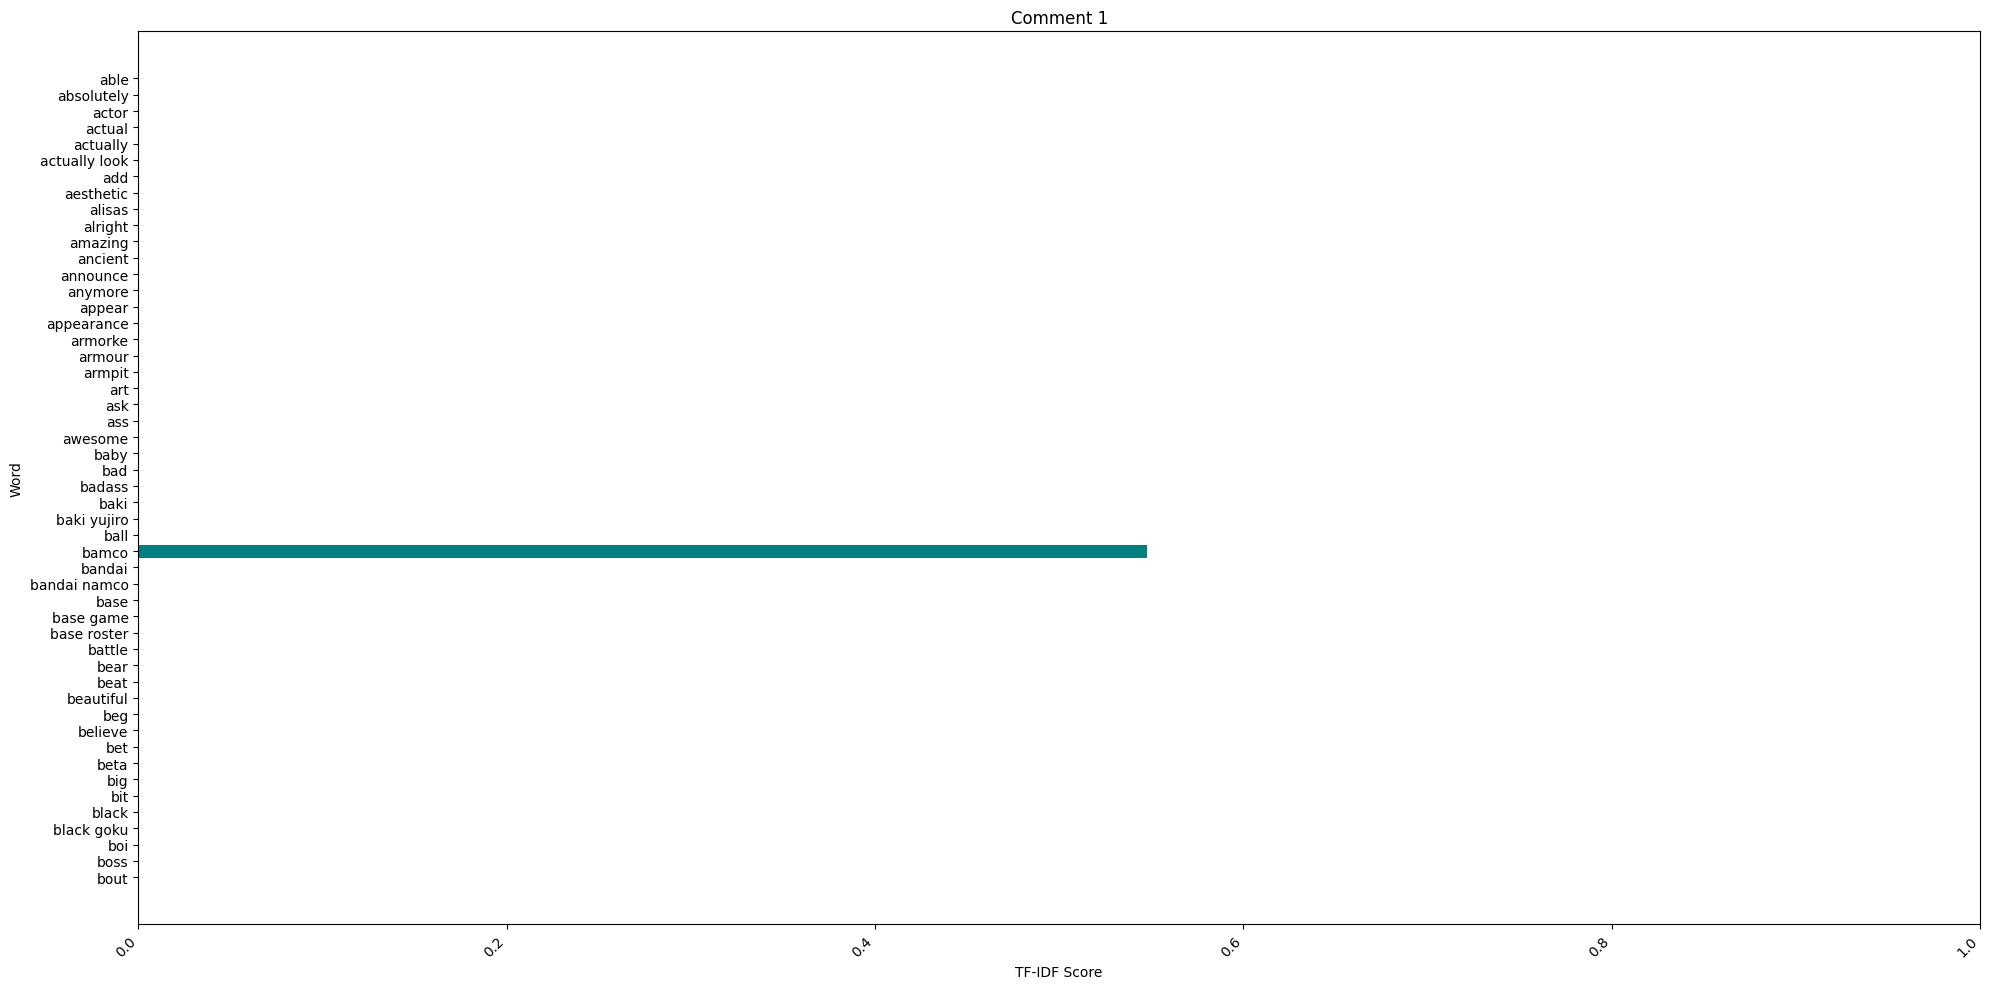


Words and TF-IDF scores for comment 2:
wow: 1.0


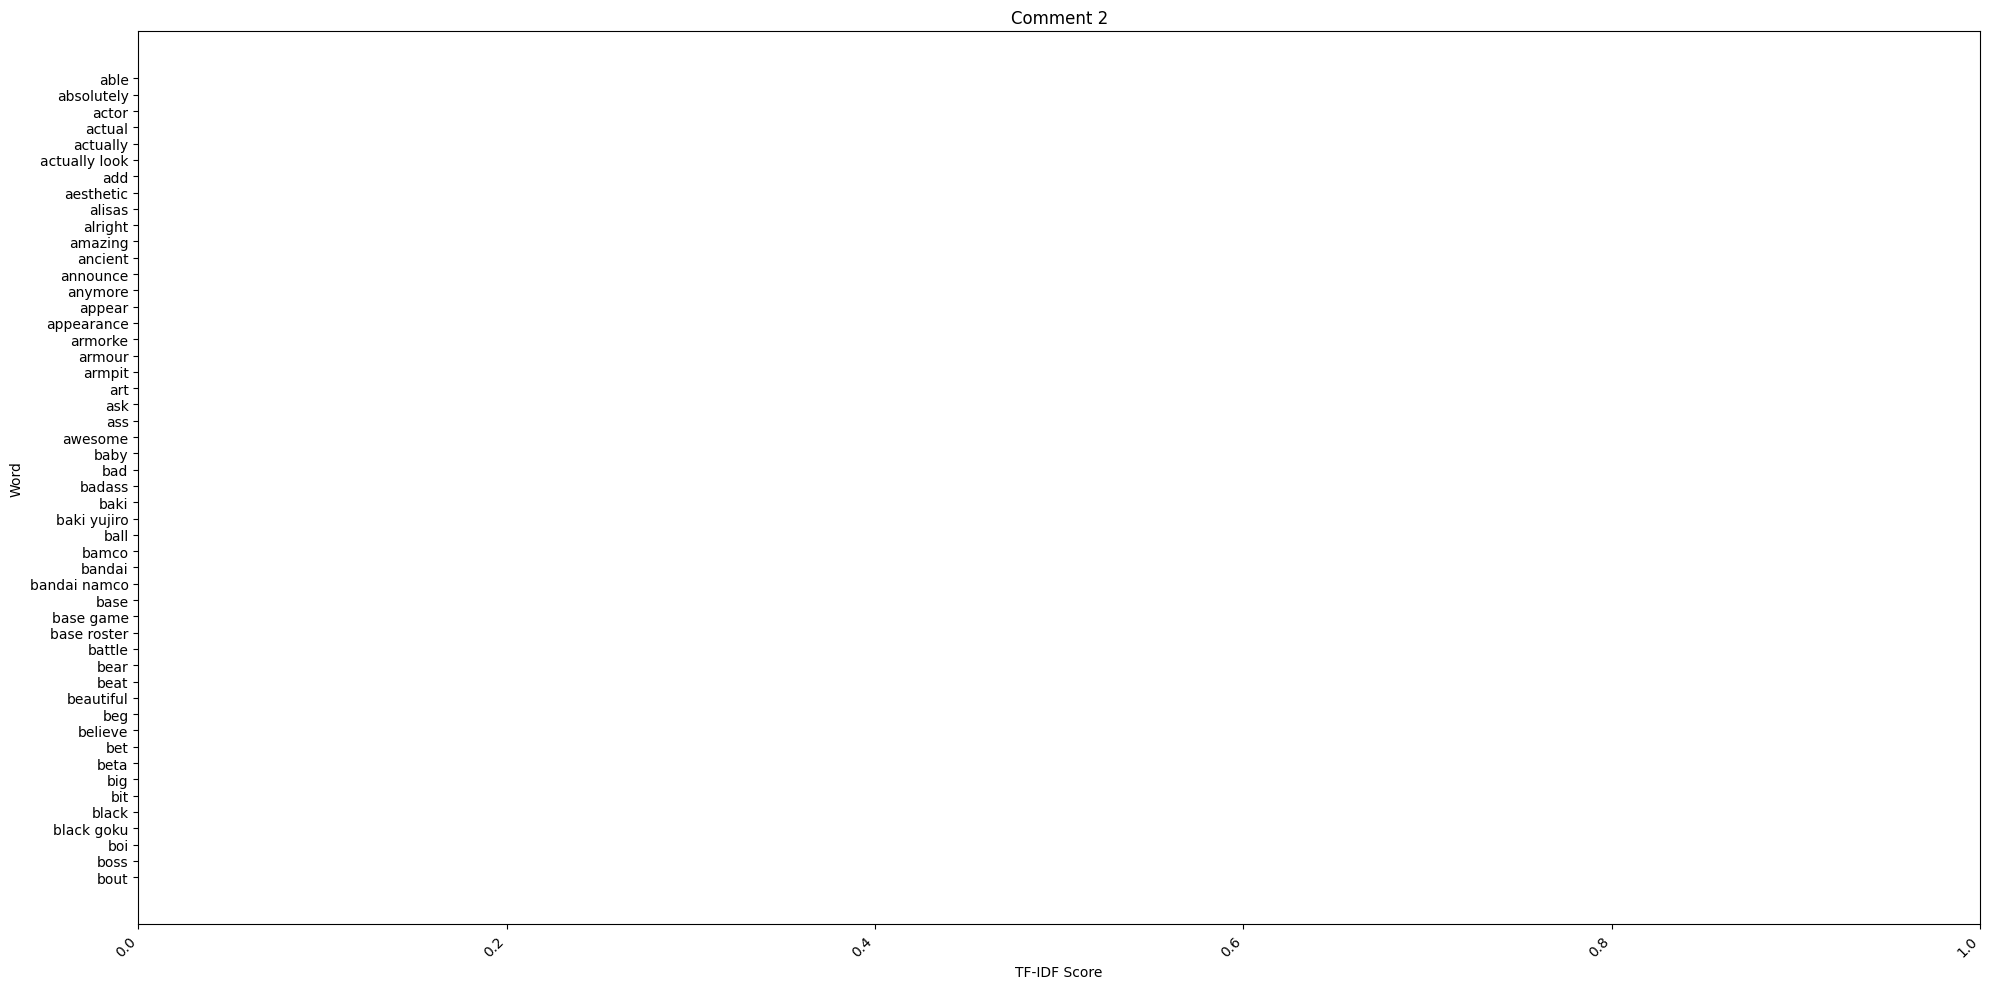

In [20]:
# define the number of comments we want to visualise so that we can break the for loop when this number is reached
number_of_comments_to_visualise = 2

# visualise the TF-IDF scores for the first x documents (comments)
for index, scores in enumerate(tfidf_matrix[:100]):  # limit to first x comments
    if index == number_of_comments_to_visualise:  # stop after x iterations, so we just graphs for the first 10 comments
        break
    plt.figure(figsize=(20, 10))
    plt.barh(tfidf_feature_names[:50], scores[:50], color='teal', )  # limit to first x features and scores, the indexing for features and socres must match
    plt.title(f"Comment {index + 1}")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Word")
    plt.xlim((0,1))
    plt.xticks(rotation=45, ha='right')  # Adjust for readability
    plt.tight_layout()
    plt.gca().invert_yaxis()  # invert y-axis

    print(f"\nWords and TF-IDF scores for comment {index + 1}:")
    for word_index, tfidf_score in enumerate(scores):
        if tfidf_score >0.0:    
            word_index = int(word_index)   # indexing issue as for some reason the word index was a float
            print(f"{tfidf_feature_names[word_index]}: {round(tfidf_score, 3)}")
    
    plt.show()

## Remove sparsity from the visualisation
The above graphs are mostly empty; we see from comment 1 has a TF-IDF score of 0.54 for the word Bamco, and none of the other features visualised are in the first 2 comments. We can implement code to only visualise the words with a score >0.0 in each comment...

Words for comment 1:
bamco 0.5475514448208861
get 0.36290698487249895
see 0.4636397598340532
view 0.5945789339577491


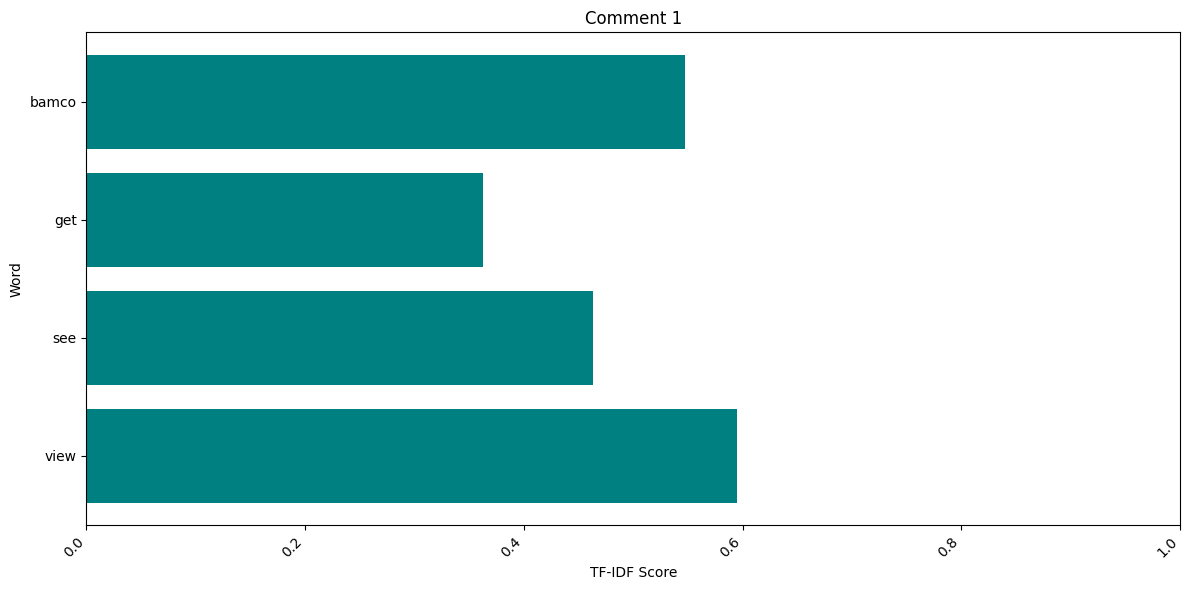

Words for comment 2:
wow 1.0


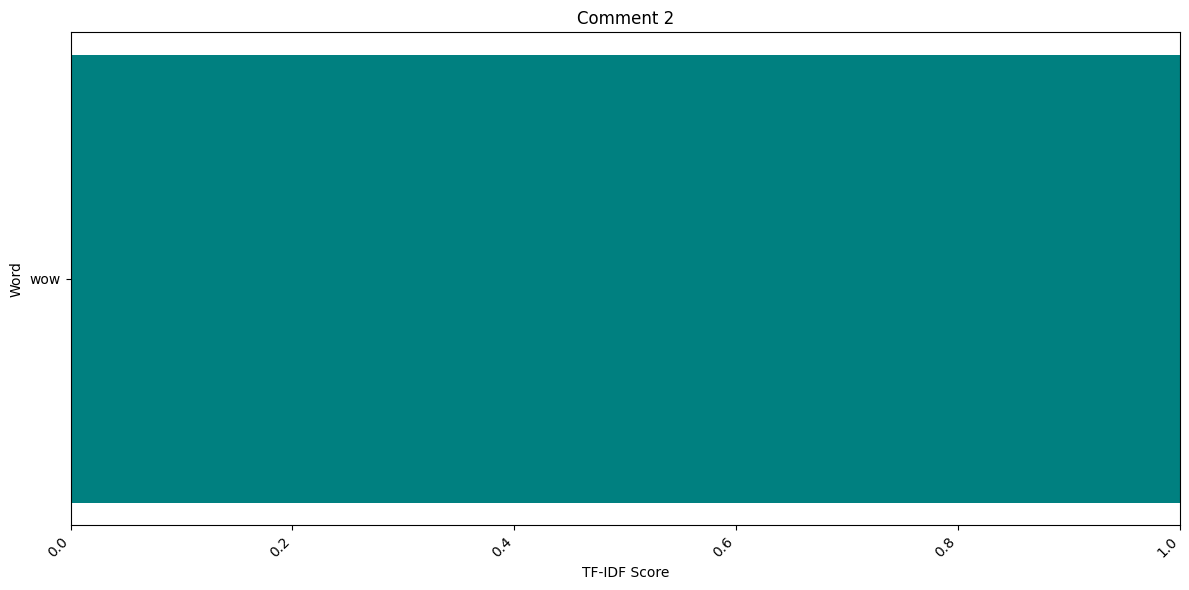

Words for comment 3:


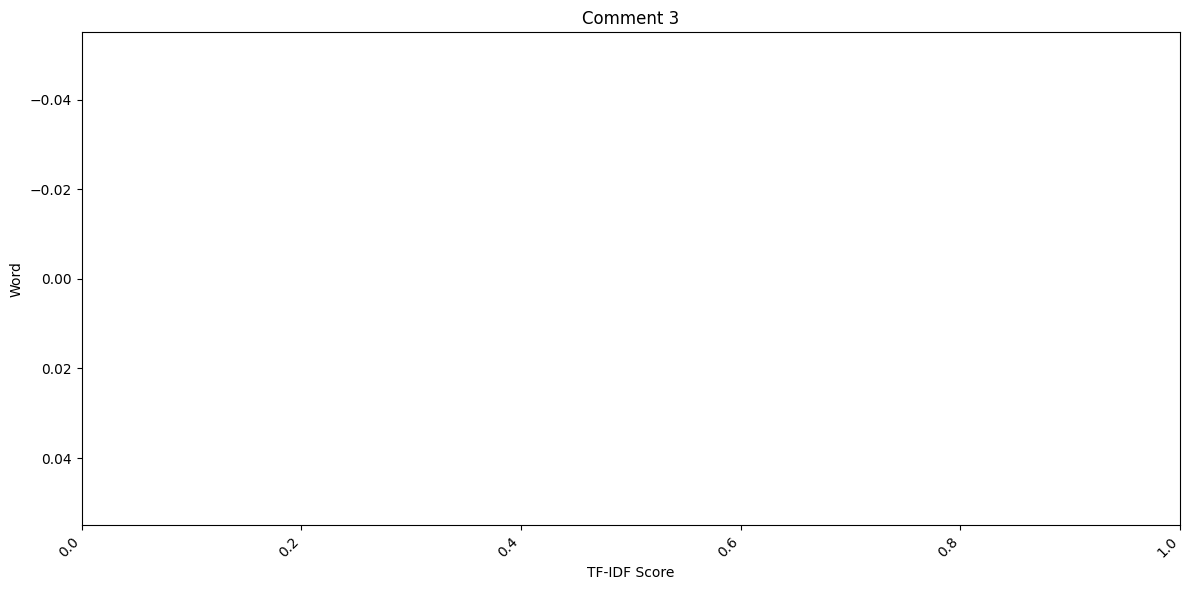

In [33]:
number_of_comments_to_visualise = 3

for index, scores in enumerate(tfidf_matrix[:10]):  # limit to first 100 comments
    if index == number_of_comments_to_visualise:  # stop after 5 iterations
        break  

    # filter scores and features for TF-IDF > 0.0 using boolean indexing
    relevant_scores = scores[scores > 0.0]    # use boolean indexing to get the indices from scores where score >0.0
    relevant_features = tfidf_feature_names[scores > 0.0]    # use boolean indexing to get the corresponding indices for the features where score >0.0
        
    plt.figure(figsize=(12, 6))
    plt.barh(relevant_features, relevant_scores, color='teal')
    plt.title(f"Comment {index + 1}")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Word")
    plt.xlim((0, 1))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.gca().invert_yaxis()

    print(f"Words for comment {index + 1}:")
    for i, v in enumerate(relevant_features):
        print(f"{v} {relevant_scores[i]}")

    file_name = f"images/tfidf_viz_comment_{index+1}.png"
    
    plt.savefig(file_name, transparent=None, dpi='figure', format="png")
    
    plt.show()

# Create the scikit-learn NMF model

In [34]:
# create an NMF model with scikit-learn
nmf = NMF(
    n_components=best_number_of_topics,   # number of topics to be extracted
    init='nndsvd',  # initialization method for the non-negative matrices; 'nndsvd' works well on sparse data
    max_iter=200,   # Maximum number of iterations for the optimization algorithm. Higher values lead to better convergence but increase computation time.
    l1_ratio=0.0,   # Regularization parameter controlling balance between L1 and L2 penalties for sparsity; 0.0 (default): No L1 penalty, only L2 penalty.
    solver='cd',    # Optimization algorithm used for NMF. 'cd' (default): Coordinate Descent. 'mu': Multiplicative Update.
    alpha_W=0.0,    # Regularization parameter for the W matrix (document-topic matrix); 0.0 (default): No regularization.
    tol=0.0001,     # Convergence tolerance for the optimization algorithm. Training stops when the change in error falls below this threshold.
    random_state=42
).fit(tfidf)

We can check out the weights given to each word in a given topic by exploring _nmf_components\__ which is an array, with each item in the array containing an array of the feature (word) weights.  _nmf_components_ contains each topic and the weighting of each feature (word), so this is a list of length x (optimal number of topics) and each item in the list is an array of feature (word) weights

In [41]:
# length should be the optimal number of topics
len(nmf.components_)

30

In [43]:
# length of the array for a given topic should be the same as the number of features
len(nmf.components_[0])

544

In [44]:
# print the weights of the first 10 words for topic 0
print(nmf.components_[0][:10])

[0.         0.         0.         0.         0.         0.
 0.         0.00850072 0.         0.        ]


## Creating valubale topics from the most heavily weighted words
- Because topic modeling is a form of unsupervised learning, summarising the topics can be a challenge.
- One solution is to go through the texts and manually create topics, but this is laborious.
- Another option is to use the words in each topic that had the highest score for that topic and map these back to the feature names.
- Let's try with the top 5 words for each topic.

## Exploring the words and topics

- We now have a model created with the 'optimal' number of topics (as defined by the highest coherence score). We also have the feature names stored in 'tfidf_feature_names'. 
- The next step is to see what words make up each topic and what the topics are, and, ultimately, we want to use the most important words, as determined by the TF-IDF weightage, to create 'topics'.
- To do this we...
    - Create a 'document_weights' variable; this will be a matrix that will tell us which topic each document most closely aligns to, e.g., \[10,3\] would mean that document 10 most closely aligns with topic 3. By examining the values in this matrix, you can understand how documents are distributed across the topics and identify which documents are most representative of each topic.
    - To do this we will:
        - Use the tf-idf vectorizer to transform our text input into a numerical representation, this will be a matrix.
        - Use the NMF model to decompose the matric into a a topics matrix and a documents matrix.
        - Applying the NMF model essentially links each document to a topic.  

In [ ]:
# convert text document into numerical tf-idf representation and apply nmf model to this

# add a variable that does the tfidf vectoriser transformer and then pass this variable in place of tfidf_vectoriser.transform below
document_weights = nmf.transform(tfidf_vectorizer.transform(texts))

In [ ]:
# set the number of words we want to use (the top x many)
number_of_words = 8

df_topic = topic_dataframe(model=nmf, 
                           feature_names=tfidf_feature_names, 
                           number_of_words=number_of_words
                          ).T    # .T transposes the dataframe

df_topic.head(2)

We have a dataframe that contains the top x most heavily weighted (important) words for a given topic. Now we'll create a dataframe that houses the topic number and a string of the words that are most closely linked with the topic.

In [ ]:
# perform operations to bring together the top x words and create a string of topic words
df_topic['topic_words'] = df_topic.apply(lambda x: [' '.join(x)], axis=1) # apply row (axis=1) operation that takes the word from each column and 
                                                                     # turns it into a list
df_topic['topic_words'] = df_topic['topic_words'].str[0]  # returns the str of first item in single item list (essentially removes the list brackets)
df_topic['topic_words'] = df_topic['topic_words'].apply(lambda x: tokenize_comment(x)) # tokenize
df_topic['topic_words'] = df_topic['topic_words'].apply(lambda x: unique_words_from_tokens(x))  # Removing duplicate words
df_topic['topic_words'] = df_topic['topic_words'].apply(lambda x: [' '.join(x)])  # returns a single item list where the item is a single string
df_topic['topic_words'] = df_topic['topic_words'].str[0]  # returns the str of first item in single item list (essentially removes the list brackets)


df_topic.head(3)

In [ ]:
# create a dataframe with only the topics and topic number
df_topic = df_topic['topic_words'].reset_index()
df_topic.columns = ['topic_number', 'topic_words']

df_topic

We now have our x number of topics and the top x words that are most closely associated with these topics...

# Summary of topics

# Next steps
- 30 topics is too many so I'm going to create a model with the number of topics set to 5-10; 10 had a 0.42 coherence score which is not far off the highest coherence score of 0.46 and involves a vastly reduced number of topics.